# 1. Sentiment Analysis of Movie Reviews using scikit-learn

In this notebook, I perform sentiment analysis of movie reviews using `scikit-learn`.

The dataset consists of 50k highly polarized (*clearly* favourable or unfavourable) movie reviews from IMBD. The set is partitioned into a labelled train set of 25k reviews and a labelled test set of 25k reviews. The reviews are preprocessed by lower-casing, removing HTML tags, and removing punctutation. The reviews are then tokenized, removing English stop words, and stemmed. Corpus vectorization is implemented using `TfidfVectorizer`. Multiple classification models are trained and tested on the results.

## Imports

In [ ]:
!pip install datasets

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import re

from nltk import PorterStemmer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

from scipy.stats import loguniform, uniform
from string import punctuation
from datasets import load_dataset

## Load IMDB Dataset

In [ ]:
ds = load_dataset('imdb')
train, test = pd.DataFrame(ds['train']), pd.DataFrame(ds['test'])

In the following DataFrame samples, a label of 0 corresponds to a negative review (*i.e.,* thumbs-down) whereas a label of 1 corresponds to a positive review (*i.e.,* thumbs-up).

In [4]:
train.sample(5)

,text,label
6293,"This movie was amusing at times, hell sometime...",0
14522,This final Voyager episode begins 23 years in ...,1
3068,There have been very few films I have not been...,0
8360,"From the stupid ""quaint African natives"" trave...",0
13726,This film is exactly what its title describes-...,1


In [5]:
test.sample(5)

,text,label
10964,"First things first, I am by no means a picky m...",0
20169,"I haven't seen this film for over 20 years, bu...",1
22354,"And she really was beautiful (Laraine Day, tha...",1
13652,"An untidy man, known as Bill, lives in a small...",1
2338,Your time and brains will be much better spent...,0


## Exploratory Data Analysis

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


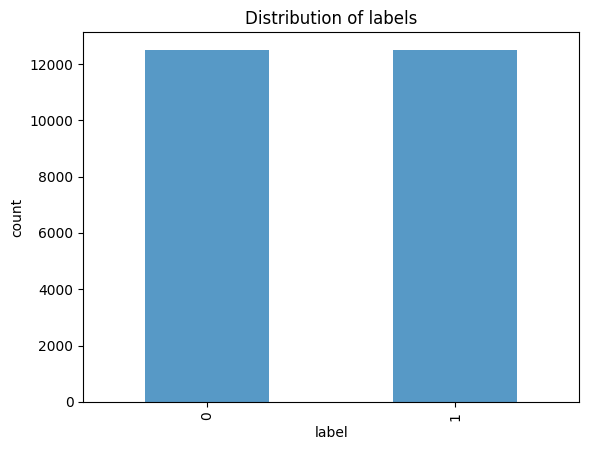

In [7]:
fig, ax = plt.subplots()
train.groupby('label').count().plot(kind='bar', alpha=0.75, ax=ax)
ax.set_ylabel('count')
ax.set_title('Distribution of labels')
ax.legend().set_visible(False)
plt.show()

From the above bar graph, the train set appears to be balanced. To confirm:

In [8]:
train['label'].value_counts()

label
0    12500
1    12500
Name: count, dtype: int64

It is instructive to read a handful of the reviews to better understand what is meant by "highly polarized."

In [9]:
thumbs_ups = train[train['label'] == 1]
thumbs_downs = train[train['label'] == 0]

In [10]:
thumbs_up_samples = thumbs_ups['text'].sample(3).to_list()
for sample in thumbs_up_samples:
    print(sample + '\n')

I saw this on a Cantonese VCD with the English subtitles. I thought the story was good but there were times when some of the subcharacters were grossly over-acting. This took away from the film as did the fairly lame musical score, which really irked me throughout the entire movie. If the musical score was improved I could overlook the few overacted scenes. Then the film would be much, much better.

For people interested in business and the corporate world, this show is simply the best of the best. As one of the former contestants of the show wrote in his blog about this innovative show: People in business finally had an audience. The whole idea is perfect; having a group of businesspeople competing against each other in business-related tasks, set in the best place in the world, New York City. Donald Trump is perfect as the boss, even though his ego is bigger than the whole universe times infinity. He also makes a lot of questionable decisions about whom to fire, which is one of the n

In [11]:
thumbs_down_samples = thumbs_downs['text'].sample(3).to_list()
for sample in thumbs_down_samples:
    print(sample + '\n')

I rented this film to see what might be a bloody, non stop action movie and got this overly sentimental and super cheap low budget action-drama that makes Kickboxer look like Die Hard. Lou and Reb are in Vietnam and as Lou saves Reb from the gooks, he gets shot in the head in what is easily one of the worst effects ever. The Vietnam scenes are shot in someones backyard, I swear! Lou is now brain damaged and Reb and him live together and own a bar. Super homoerotic. Lou is convinced to fight in a cage for money and Reb goes on a killing spree to get him back. There is no good fight scenes at all, the punches are two inches away from a person. Characters personalities change in matter of seconds. One guy is a bad and in the next scene he's good. The acting is horrid and the music is some overly sentimental Frank Stallone sounding song that would make you sick. I hated this film.

Such a pretentious and lame attempt to hipness. Diabolical script and dialogue and truly embarrassing acting.

## Preprocessor

The preprocessor processes and cleans movie reviews through lower-casing, removing HTML tags, and removing punctuation.

In [12]:
class Preprocessor(BaseEstimator, TransformerMixin):
    @staticmethod
    def strip_html(X):
        """Remove HTML tags from a corpus X."""
        return [re.sub(r'<[^>]+>', ' ', doc) for doc in X]

    @staticmethod
    def strip_forward_slashes(X):
        """Replace / by a space in a corpus X."""
        return [doc.replace('/', ' ') for doc in X]

    @staticmethod
    def strip_punctuation(X):
        """Remove punctuation from a corpus X."""
        def strip_punc_from_doc(doc: str) -> str:
            """Remove punctuation from a single document doc."""
            doc_trans = doc
            for p in punctuation:
                doc_trans = doc_trans.replace(p, '')
            return doc_trans
        return [strip_punc_from_doc(doc) for doc in X]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.Series):
            X = X.to_list()

        X_trans = X
        X_trans = [doc.lower() for doc in X_trans]
        X_trans = Preprocessor.strip_html(X_trans)
        X_trans = Preprocessor.strip_forward_slashes(X_trans)
        X_trans = Preprocessor.strip_punctuation(X_trans)

        return X_trans

To see Preprocessor in action, pick a random movie review:

In [13]:
preprocessor = Preprocessor()

doc = train['text'].sample()
doc_preprocessed = preprocessor.transform(doc)

print(doc.to_list()[0])
print()
print(doc_preprocessed[0])

Brilliant execution in displaying once and for all, this time in the venue of politics, of how "good intentions do actually pave the road to hell". Excellent!

brilliant execution in displaying once and for all this time in the venue of politics of how good intentions do actually pave the road to hell excellent


## Tokenizer

The tokenizer removes English stop words and stems the corpus.

In [14]:
class Tokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, stemmer, stop_words=None):
        """
        Initialize a Tokenizer.

        :param stemmer: An instance of a word stemmer
        :param stop_words: A list of words to remove from the corpus
        """
        self.stemmer = stemmer
        self.stop_words = stop_words

    def remove_stop_words(self, X):
        """Remove stop words from a corpus X."""
        def remove_stop_words_from_doc(doc):
            """Remove stop words from a document doc."""
            doc_trans = []
            for word in doc:
                if word not in self.stop_words:
                    doc_trans.append(word)
            return doc_trans
        return [remove_stop_words_from_doc(doc) for doc in X]

    def stem(self, X):
        """Stem a corpus X."""
        def stem_doc(doc):
            """Stem a document doc."""
            return_doc = []
            for word in doc:
                return_doc.append(self.stemmer.stem(word))
            return return_doc
        return [stem_doc(doc) for doc in X]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.Series):
            X = X.to_list()

        X_trans = X
        X_trans = [doc.split() for doc in X_trans]
        X_trans = self.remove_stop_words(X_trans)
        X_trans = self.stem(X_trans)
        X_trans = [' '.join(doc) for doc in X_trans]

        return X_trans

To see Tokenizer in action, transform the previously preprocessed movie review.

In [15]:
tokenizer = Tokenizer(PorterStemmer(), ENGLISH_STOP_WORDS)

doc_tokenized = tokenizer.transform(doc_preprocessed)

print(doc_preprocessed[0])
print()
print(doc_tokenized[0])

brilliant execution in displaying once and for all this time in the venue of politics of how good intentions do actually pave the road to hell excellent

brilliant execut display time venu polit good intent actual pave road hell excel


## Classification

In [16]:
X_train, X_test, y_train, y_test =\
    train['text'], test['text'], train['label'], test['label']

### Logistic Regression

In [17]:
vectorizer = TfidfVectorizer(
    max_df = 0.95,
    min_df = 2,
    max_features = 10_000,
    strip_accents='unicode'
)

cleaner = Pipeline([
    ('preprocessor', Preprocessor()),
    ('tokenizer', Tokenizer(PorterStemmer(), ENGLISH_STOP_WORDS)),
    ('vectorizer', vectorizer)
])

In [18]:
lr = LogisticRegression(
    penalty='l2',
    solver='saga',
    max_iter=500
)

pipe = Pipeline([
    ('cleaner', cleaner),
    ('classifier', lr)
])

param_distributions = {
    'classifier__C': loguniform(1e-2, 1e2)
}

search_lr = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    refit=True
)

In [19]:
search_lr.fit(X_train, y_train);

In [20]:
test_score_lr = search_lr.score(X_test, y_test)

print(f'Best model: {search_lr.best_params_}')
print(f'F1-score: {test_score_lr}')

Best model: {'classifier__C': 0.5879592567634434}
F1-score: 0.8741041567128525


### Random Forest

In [21]:
rfc = RandomForestClassifier()

pipe = Pipeline([
    ('cleaner', cleaner),
    ('classifier', rfc)
])

param_distributions = {
    'classifier__n_estimators': [10, 30, 100, 300, 1000],
    'classifier__max_depth': list(range(10, 101)),
    'classifier__min_samples_split': list(range(2, 11)),
    'classifier__min_samples_leaf': list(range(1, 11))
}

search_rfc = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    refit=True
)

In [22]:
search_rfc.fit(X_train, y_train);

In [23]:
test_score_rfc = search_rfc.score(X_test, y_test)

print(f'Best model: {search_rfc.best_params_}')
print(f'Test F1-score: {test_score_rfc}')

Best model: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 68}
Test F1-score: 0.8474535745596556


### Support Vector Machine

In [24]:
svc = LinearSVC(penalty='l2')

pipe = Pipeline([
    ('cleaner', cleaner),
    ('classifier', svc)
])

param_distributions = {
    'classifier__C': loguniform(1e-2, 1e2),
    'classifier__max_iter': [10, 30, 100, 300, 1000]
}

search_svc = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    refit=True
)

In [ ]:
search_svc.fit(X_train, y_train);

In [26]:
test_score_svc = search_svc.score(X_test, y_test)

print(f'Best model: {search_svc.best_params_}')
print(f'Test F1-score: {test_score_svc}')

Best model: {'classifier__C': 0.06227692687478894, 'classifier__max_iter': 10}
Test F1-score: 0.8745676460064407


## Conclusion

In [27]:
print(f'Test F1-scores:')
print(f'    Logistic regression: {test_score_lr}')
print(f'    Random forest: {test_score_rfc}')
print(f'    Support Vector Machine: {test_score_svc}')

Test F1-scores:
    Logistic regression: 0.8741041567128525
    Random forest: 0.8474535745596556
    Support Vector Machine: 0.8745676460064407
